<a href="https://colab.research.google.com/github/nilesh0109/RL-assignments/blob/master/Easy21_task4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, rc

In [0]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

rc('font', **font)

# ENVIRONMENT

In [0]:
class human:
  def __init__(self, name):
    self.name=name
    self.black_cards = []
    self.red_cards = []
    
class state:
  def __init__(self, d_card, p_cards):
    self.d_card = d_card.black_cards[0]
    self.p_sum = int(np.sum(p_cards.black_cards) - np.sum(p_cards.red_cards))
    if self.p_sum > 21:
      self.p_sum = 22
    elif self.p_sum < 1:
      self.p_sum = 0
        

In [0]:
class Easy21:
  def start(self):
    self.dealer = human('dealer')
    self.player = human('player')
    self.draw(self.dealer, 'black')
    self.draw(self.player, 'black')
    self.s = state(self.dealer, self.player)
    self.isGameOver = False
    
  def getScore(self, player):
    return np.sum(player.black_cards) - np.sum(player.red_cards)
  
  def draw(self, drawer, color=None):
    if color=='black':
      drawer.black_cards.append(np.random.randint(1,11))
    else:
      color = np.random.choice(2, p=[1/3, 2/3])
      if color == 0:
        drawer.red_cards.append(np.random.randint(1,11))
      else:
        drawer.black_cards.append(np.random.randint(1,11))
      self.s = state(self.dealer, self.player)
    
  def step(self, a='hit'):
    if a=='hit':
      self.draw(self.player)
    else:
      self.draw(self.dealer)
      dealer_score = self.getScore(self.dealer)
      while(dealer_score > 0 and dealer_score <17):
        #since dealer is drawing here so player is sticking
        self.draw(self.dealer,'stick')
        dealer_score = self.getScore(self.dealer)
      self.isGameOver = True
    r = self.calc_rewards()
    
    return self.s, r
  
  def calc_rewards(self):
    player_score = self.getScore(self.player)
    dealer_score = self.getScore(self.dealer)
    #print(self.player.name, self.player.black_cards, self.player.red_cards)
    #print(self.dealer.name, self.dealer.black_cards, self.dealer.red_cards)
    #print(player_score, dealer_score)
    if player_score < 1 or player_score > 21:
      self.isGameOver = True
      return -1
    elif dealer_score < 1 or dealer_score > 21:
      self.isGameOver = True
      return 1
    else:
      if self.isGameOver:
        #to avoid the divide by zero error
        abs_reward = player_score - dealer_score
        normalized_reward = 0 if abs_reward == 0 else abs_reward / np.abs(abs_reward)
        return normalized_reward
      else:
        return 0
    
    

# SARSA AND MONTE-CARLO 

In [0]:
class Agent:
  def __init__(self):
    self.label ='player'
    
  def play_Easy21(self):
    self.actions ={0:'hit', 1:'stick'}
    self.value = np.zeros((10, 23,len(self.actions)), dtype=np.float64)
    self.N_sa = np.zeros((10, 23,len(self.actions)), dtype=np.int32)
    self.N_s = np.zeros((10, 23), dtype=np.int32)
    self.N0 = 100
    self.gamma = 1
  
  def reset(self):
    self.game = Easy21()
    self.game.start()
    
    
  def eps_greedy_policy(self):
    '''Implemeting Monte Carlo control using e-greedy'''
    state = self.game.s
    s = state.d_card -1, state.p_sum
    eps = self.N0/(self.N0 + self.N_s[s])
    p = np.random.random()
    val = self.value[s] 
    if p > eps:
      next_action = np.argmax(val)
    else:
      next_action = np.random.randint(len(self.actions))
    return next_action
 
  def run_episodes(self, num_episodes=100, method='SARSA', sarsa_lambda=1):
    for i in range(num_episodes):
      self.reset()
      if method== 'SARSA':
        self.do_SARSA_control(sarsa_lambda)
      else:
        self.do_Monte_Carlo_control()
        
  
  def do_Monte_Carlo_control(self):
    trajectory = []

    while not self.game.isGameOver:
      next_action = self.eps_greedy_policy()
      curr_state = self.game.s

      next_s, reward = self.game.step(self.actions[next_action])
      seen_trajectory = (curr_state, next_action, reward)
      trajectory.append(seen_trajectory)
    
      G_t = 0
    for i in np.arange(len(trajectory) - 1, -1, -1):
      state, action_taken, received_r = trajectory[i]
      #accumlating the G(t) through DP from end to first state in trjectory
      G_t += received_r
      s = state.d_card - 1, state.p_sum
      self.N_s[s] += 1
      state_act = *s, action_taken
      self.N_sa[state_act] += 1
      alpha = 1/self.N_sa[state_act]
      self.value[state_act] += alpha * (G_t - self.value[state_act])
      

  def do_SARSA_control(self, sarsa_lambda):
    #Eligibility Traces
    E_sa = np.zeros((10, 23,len(self.actions)), dtype=np.float64)

    while not self.game.isGameOver:
      next_action = self.eps_greedy_policy()
      curr_state = self.game.s
      s_prime, reward = self.game.step(self.actions[next_action])
      
      s = curr_state.d_card - 1, curr_state.p_sum
      s_a = *s, next_action 
      
      if not self.game.isGameOver:
        a_prime = self.eps_greedy_policy()
        s_prime = s_prime.d_card - 1, s_prime.p_sum
        s_prime_a_prime = *s_prime, a_prime
        td_error = reward + (self.gamma * self.value[s_prime_a_prime]) - self.value[s_a]
      else:
        td_error = reward - self.value[s_a]
      
      self.N_s[s] += 1
      self.N_sa[s_a] += 1
      alpha = 1/self.N_sa[s_a]
      
      E_sa[s_a] += 1

      self.value += alpha * td_error * E_sa

      E_sa *= sarsa_lambda * self.gamma
      
      
            

# SARSA FUNCTION APPROXIMATION

In [0]:
class Agent_funct_apprx:
  def __init__(self):
    self.label ='player'
    
  def play_Easy21(self):
    self.actions ={0:'hit', 1:'stick'}
    self.values = np.zeros((10, 23,len(self.actions)), dtype=np.float64)
    self.gamma = 1
    self.init_features()
  
  def reset(self):
    self.game = Easy21()
    self.game.start()
  
  def eps_greedy_policy(self):
    '''Implemeting Monte Carlo control using e-greedy'''
    state = self.game.s
    s = state.d_card -1, state.p_sum
    eps = 0.05
    p = np.random.random()
    #values = np.array([self.getValue(state, action) for action in list(self.actions.keys())])
    if p > eps:
      next_action = np.argmax(self.values[s])
    else:
      next_action = np.random.randint(len(self.actions))
    return next_action
 
  def run_episodes(self, num_episodes=100, method='SARSA_ZERO', sarsa_lambda=1):
    for i in range(num_episodes):
      self.reset()
      #self.do_SARSA_control(sarsa_lambda)
      if method== 'SARSA_ZERO':
        self.do_SARSA_zero_linear_approximation()
      else:
        self.do_SARSA_lambda_linear_approximation(sarsa_lambda)
        
      
  def getValue(self, state, action):
    return np.sum(self.getFeatureVector(state, action) * self.w)
  
  def init_features(self):
    self.dealer_card_buckets = [[1, 4], [4, 7], [7, 10]]
    self.player_sum_buckets = [[1, 6], [4, 9], [7, 12], [10, 15], [13, 18], [16, 21]]
    self.action_buckets = ['hit', 'stick']
    num_axis1, num_axis2, num_axis3 = len(self.dealer_card_buckets), len(self.player_sum_buckets), len(self.action_buckets)
    self.num_features = num_axis1 * num_axis2 * num_axis3
    self.w = np.zeros(self.num_features + 1)
     
  def getFeatureVector(self, state, action):

    num_axis1, num_axis2, num_axis3 = len(self.dealer_card_buckets), len(self.player_sum_buckets), len(self.action_buckets)
    feature_vector = np.zeros(num_axis1 * num_axis2 * num_axis3 + 1)
    feature_matrix = np.zeros((num_axis1, num_axis2, num_axis3))
      
    axis1_indices = [ind for ind, minMaxLimits in enumerate(self.dealer_card_buckets) if state.d_card >= minMaxLimits[0] and state.d_card <= minMaxLimits[1]]
    axis2_indices = [ind for ind, minMaxLimits in enumerate(self.player_sum_buckets) if state.p_sum >= minMaxLimits[0] and state.p_sum <= minMaxLimits[1]]
    axis3_index = self.action_buckets.index(self.actions[action])
      
    if len(axis1_indices)> 0 and  len(axis2_indices) > 0:
      feature_matrix[axis1_indices, axis2_indices, axis3_index] = 1
    flattened_feature_matrix = feature_matrix.flatten()
    feature_vector = np.concatenate(([1], flattened_feature_matrix))
    return feature_vector
    
  def do_SARSA_zero_linear_approximation(self): 
    lr_rate = 0.01
      
    while not self.game.isGameOver:

      next_action = self.eps_greedy_policy()
      curr_state = self.game.s
      feature_vec = self.getFeatureVector(curr_state, next_action)

      s_prime, r = self.game.step(self.actions[next_action])
      if not self.game.isGameOver:
        a_prime = self.eps_greedy_policy()
        error_term = r + (self.gamma * self.getValue(s_prime, a_prime)) - self.getValue(curr_state, next_action)
      else:
        error_term = r - self.getValue(curr_state, next_action)
      self.w += lr_rate * error_term * feature_vec
      
      s_at = curr_state.d_card - 1, curr_state.p_sum, next_action
      self.values[s_at] = self.getValue(curr_state, next_action)
      
  def do_SARSA_lambda_linear_approximation(self, sarsa_lambda): 
    lr_rate = 0.01
    #E_sa = np.zeros((10, 23,len(self.actions)), dtype=np.float64)  
    E_sa = np.zeros_like(self.w)
    
    while not self.game.isGameOver:

      next_action = self.eps_greedy_policy()
      curr_state = self.game.s
      feature_vec = self.getFeatureVector(curr_state, next_action)

      s_prime, r = self.game.step(self.actions[next_action])
      if not self.game.isGameOver:
        a_prime = self.eps_greedy_policy()
        error_term = r + (self.gamma * self.getValue(s_prime, a_prime)) - self.getValue(curr_state, next_action)
      else:
        error_term = r - self.getValue(curr_state, next_action)
      E_sa = self.gamma * sarsa_lambda * E_sa + feature_vec
      self.w += lr_rate * error_term * E_sa
      
      s_at = curr_state.d_card - 1, curr_state.p_sum, next_action
      self.values[s_at] = self.getValue(curr_state, next_action)
      
      
      
            

In [0]:
approx_agent = Agent_funct_apprx()
approx_agent.play_Easy21()
approx_agent.reset()
approx_agent.do_SARSA_lambda_linear_approximation(0.5)

# SARSA(lambda) value function Plot

In [0]:
approx_agent = Agent_funct_apprx()
approx_agent.play_Easy21()
approx_agent.run_episodes(500000, 0.8)

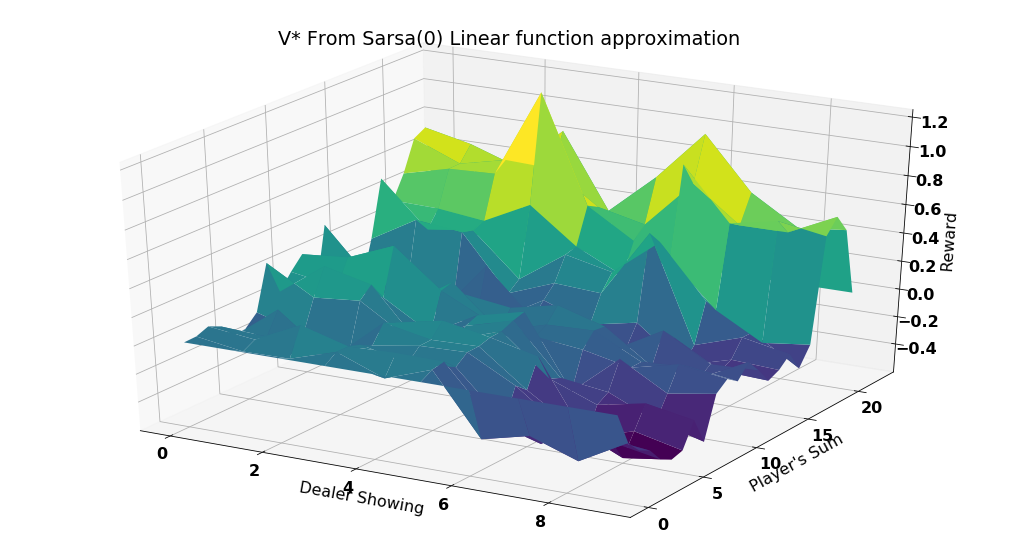

In [0]:
fig,ax = plt.subplots(1,1, figsize=(18,10))
ax = plt.axes(projection='3d')
x,y,z = approx_agent.values.shape
XX,YY = np.meshgrid(np.arange(x), np.arange(y), indexing='ij')
z = np.max(approx_agent.values, axis=2)

ax.set_title('V* From Sarsa(0) Linear function approximation')
ax.set_xlabel('Dealer Showing')
ax.set_ylabel("Player's Sum")
ax.set_zlabel('Reward')
ax.plot_surface(XX, YY, z, rstride=1, cstride=1,cmap='viridis', edgecolor='none')

# **SARSA ZERO FUNCTION APPROXIMATION PLOT**

In [0]:
approx_agent = Agent_funct_apprx()
approx_agent.play_Easy21()
approx_agent.run_episodes(500000, 0.5)

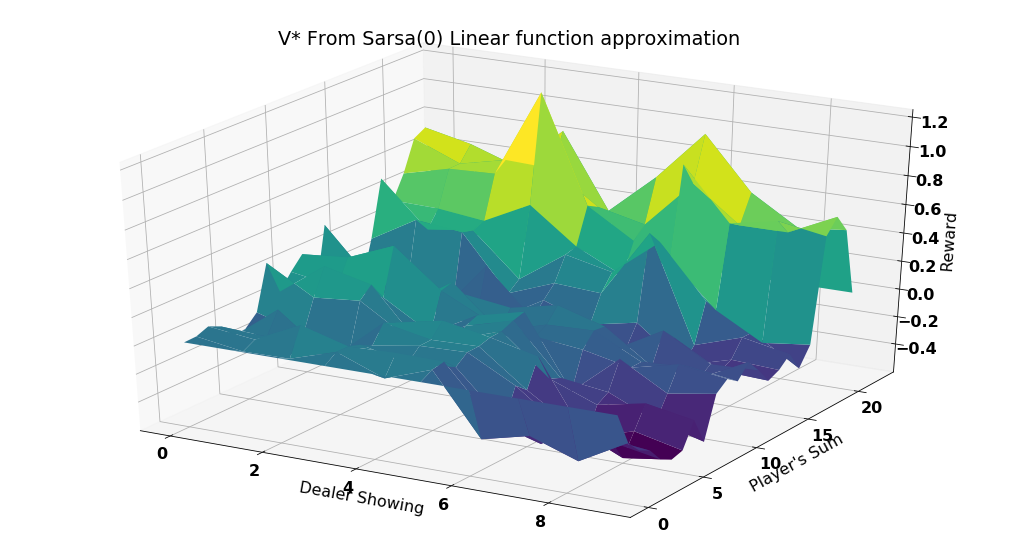

In [0]:
fig,ax = plt.subplots(1,1, figsize=(18,10))
ax = plt.axes(projection='3d')
x,y,z = approx_agent.values.shape
XX,YY = np.meshgrid(np.arange(x), np.arange(y), indexing='ij')
z = np.max(approx_agent.values, axis=2)

ax.set_title('V* From Sarsa(0) Linear function approximation')
ax.set_xlabel('Dealer Showing')
ax.set_ylabel("Player's Sum")
ax.set_zlabel('Reward')
ax.plot_surface(XX, YY, z, rstride=1, cstride=1,cmap='viridis', edgecolor='none')

# Monte-Carlo Results (without Function Approximation)

In [0]:
monte_agent = Agent()
monte_agent.play_Easy21()
monte_agent.run_episodes(500000, method='Monte-Carlo')

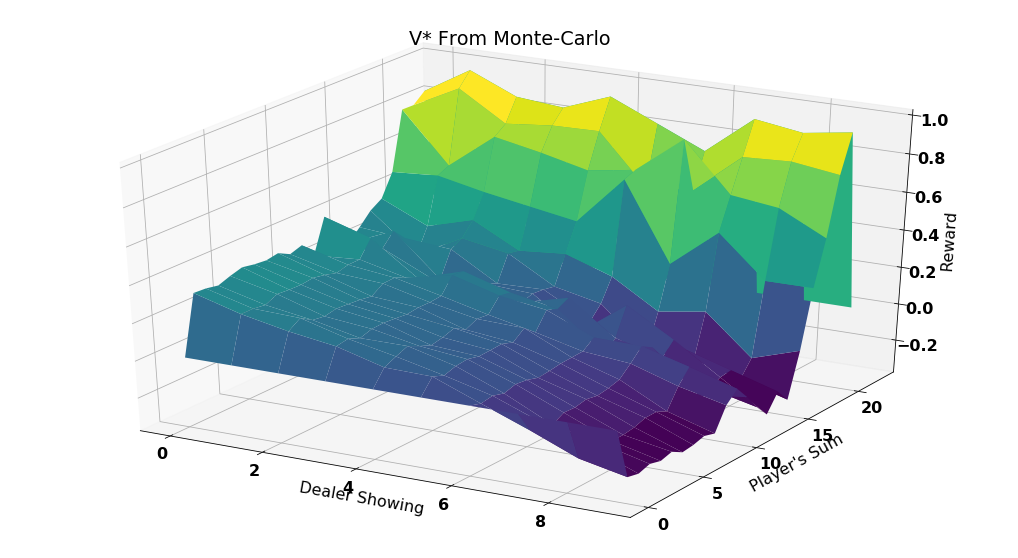

In [0]:
fig,ax = plt.subplots(1,1, figsize=(18,10))
ax = plt.axes(projection='3d')
x,y,z = monte_agent.value.shape
XX,YY = np.meshgrid(np.arange(x), np.arange(y), indexing='ij')
z = np.max(monte_agent.value, axis=2)

ax.set_title('V* From Monte-Carlo')
ax.set_xlabel('Dealer Showing')
ax.set_ylabel("Player's Sum")
ax.set_zlabel('Reward')
ax.plot_surface(XX, YY, z, rstride=1, cstride=1,cmap='viridis', edgecolor='none')

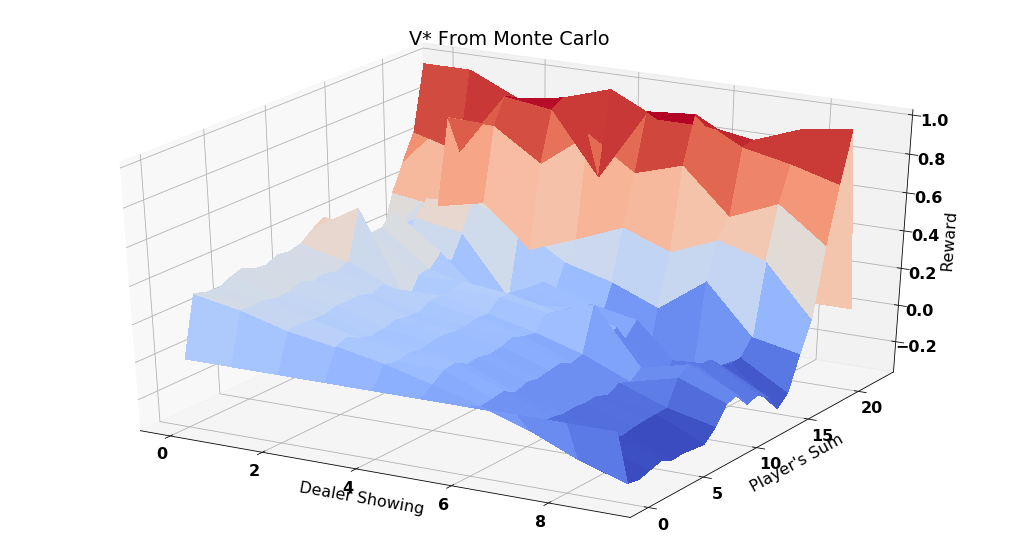

In [0]:
fig,ax = plt.subplots(1,1, figsize=(18,10))
ax = plt.axes(projection='3d')
x,y,z = monte_agent.value.shape
XX,YY = np.meshgrid(np.arange(x), np.arange(y), indexing='ij')
z = np.max(monte_agent.value, axis=2)
ax.set_title('V* From Monte Carlo')
ax.set_xlabel('Dealer Showing')
ax.set_ylabel("Player's Sum")
ax.set_zlabel('Reward')
ax.plot_surface(XX, YY, z, rstride=1, cstride=1, cmap=cm.coolwarm,
                         linewidth=0, antialiased=False)

# SARSA(lambda) Results (without Function Approximation)

In [0]:
sarsa_agent = Agent()
sarsa_agent.play_Easy21()
sarsa_agent.run_episodes(500000, method='SARSA', sarsa_lambda=0.2)

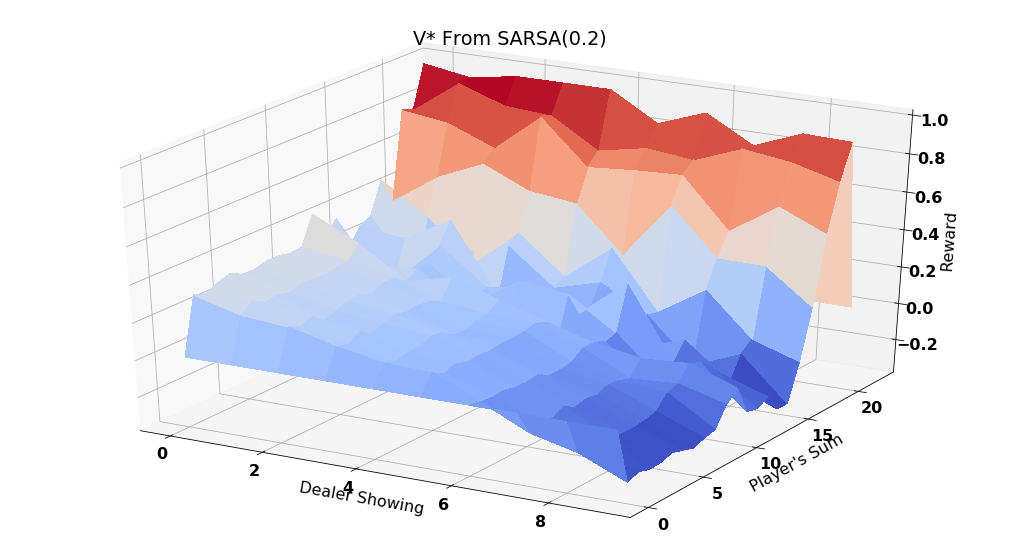

In [0]:
fig,ax = plt.subplots(1,1, figsize=(18,10))
ax = plt.axes(projection='3d')
x,y,z = sarsa_agent.value.shape
XX,YY = np.meshgrid(np.arange(x), np.arange(y), indexing='ij')
z = np.max(sarsa_agent.value, axis=2)
ax.set_title('V* From SARSA(0.2)')
ax.set_xlabel('Dealer Showing')
ax.set_ylabel("Player's Sum")
ax.set_zlabel('Reward')
ax.plot_surface(XX, YY, z, rstride=1, cstride=1, cmap=cm.coolwarm,
                         linewidth=0, antialiased=False)


# MSE Plots

In [0]:
def run_Episodes():
  lambdas = np.arange(0,1.1,0.1)
  a = []
  for ind, _lambda in enumerate(lambdas):
    a.append(Agent_funct_apprx())
    a[ind].play_Easy21()
    a[ind].run_episodes(1000, _lambda)
  return a


In [0]:
sarsa_agents = run_Episodes()

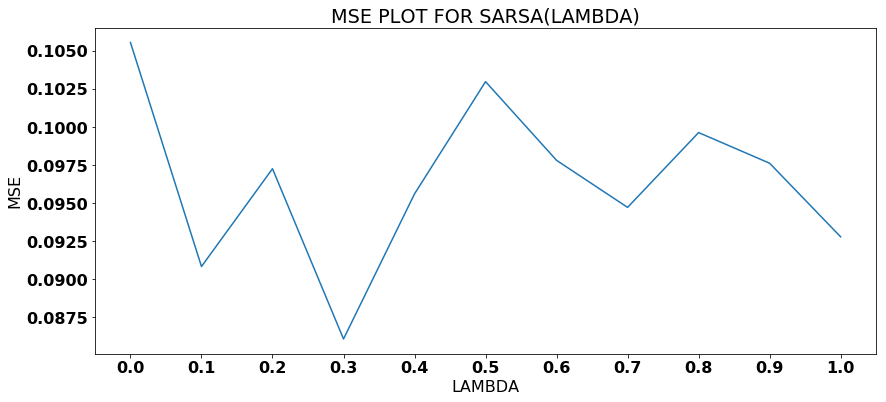

In [0]:
fig, ax = plt.subplots(1,1, figsize=(14,6))
MSE = []
for ind, agent in enumerate(sarsa_agents):
  MSE.append(np.mean(np.square(agent.values - monte_agent.value)))
ax.set_xticks(np.arange(0,1.1,0.1))
ax.set_title('MSE PLOT FOR SARSA(LAMBDA)')
ax.set_xlabel('LAMBDA')
ax.set_ylabel('MSE')
ax.plot(np.arange(0,1.1,0.1), MSE)


# SARSA Function approximation Learning Curve

In [0]:
def Analyze_SARSA_Learning(Learnt_Monte_Agent):
  fig, ax = plt.subplots(1,1, figsize=(14,10))
  lambdas = np.arange(0,1.1,0.25)
  NUM_EPISODES = 40000
  MSE_per_episode = np.zeros((NUM_EPISODES, len(lambdas)))
  for ind, _lambda in enumerate(lambdas):
    a = Agent_funct_apprx()
    a.play_Easy21()
    for epi_ind in range(NUM_EPISODES):
      a.reset()
      a.do_SARSA_lambda_linear_approximation(_lambda)
      MSE = np.mean(np.square(a.values - Learnt_Monte_Agent.value))
      MSE_per_episode[epi_ind, ind] = MSE
    ax.plot(np.arange(NUM_EPISODES), MSE_per_episode[:, ind], label='lambda={:02f}'.format(_lambda))
  ax.set_title('MSE PLOT')
  ax.set_xlabel('EPISODES')
  ax.set_ylabel('MSE')
  ax.legend()
    

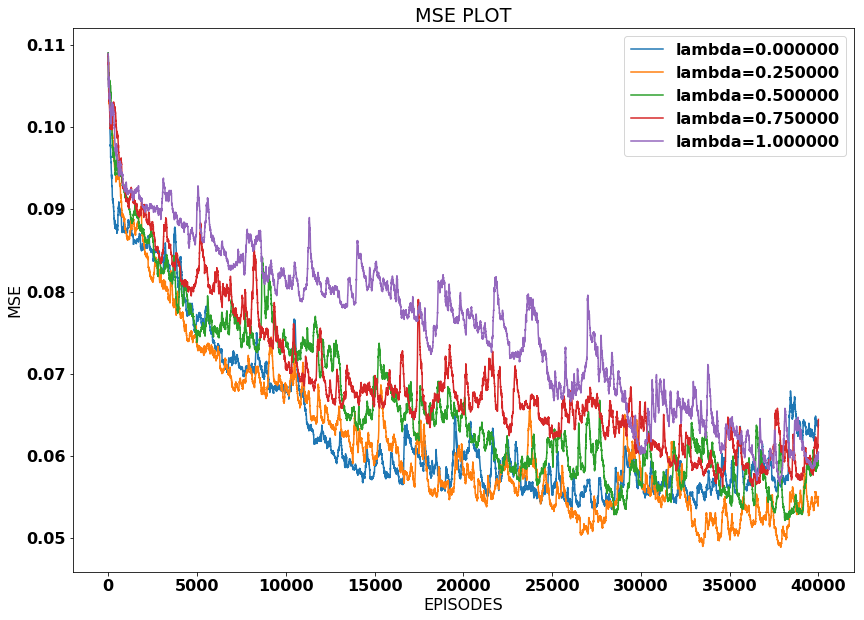

In [0]:
Analyze_SARSA_Learning(monte_agent)